In [11]:
%matplotlib inline
import os, glob, sqlite3, json
import numpy as np
import pandas as pd
# db = sqlite3.connect('../db.sqlite')
db = sqlite3.connect('../db_preprocessed.sqlite')
db.row_factory = lambda x,y: dict(sqlite3.Row(x,y))
def query_db(q, p=[]):
    return db.cursor().execute(q, p).fetchall()
db.cursor().executescript(open('../src/db_init.sql').read())
db.commit()
cur = db.cursor()

# Analyse alignment scores

In [12]:
g = glob.glob('../output/sample-A/15dec/tablecolsims/*')
colsims = pd.concat([pd.read_csv(f,sep='\t', index_col=0) for f in g])
colsims = colsims.drop(columns=['columngauss'])

colsims = colsims.set_index(['table1', 'table2', 'col1', 'col2'])
colsims = colsims.replace(0, np.nan)

colagg = ['columnjacc', 'columntype', 'columncos']
colsims['colagg'] = colsims[colagg].max(axis=1)
colsims = colsims.drop(columns=colagg)

colsims.describe()

columncos    columnjacc  columntype     headercos
count  684824.000000  13927.000000    124508.0  1.138101e+06
mean        0.592325      0.318685         1.0  6.602651e-01
std         0.242651      0.239818         0.0  1.863165e-01
min        -0.583886      0.003906         1.0 -4.262396e-01
25%         0.443294      0.152344         1.0  5.619040e-01
50%         0.635959      0.269531         1.0  6.747493e-01
75%         0.770935      0.425781         1.0  7.759588e-01
max         1.000000      1.000000         1.0  1.000000e+00

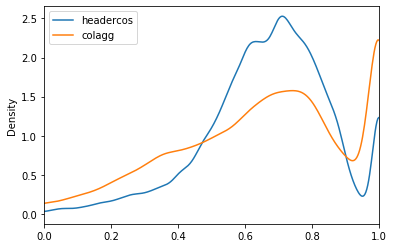

In [15]:
colsims[['headercos', 'colagg']].head(100000).plot.density(xlim=[0,1])

In [16]:
def max_align(S):
    match = {}
    na, nb = S.shape
    a, b = list(range(na)), list(range(nb))
    while a and b:
        S_ = S[a][:,b]
        s, t = np.unravel_index(S_.argmax(), S_.shape)
        s, t = a[s], b[t]
        match[s] = t
        a.remove(s)
        b.remove(t)
    return match

import collections
max_count = collections.Counter()
for i,((t1,t2),g) in enumerate(colsims.groupby(['table1', 'table2'])):
    m = {c:g[c].unstack().values for c in g.columns}
    a = max_align(np.nanmax(list(m.values()), axis=0)).items()
    max_count.update( [g.loc[(t1,t2,c1,c2)].idxmax() for c1,c2 in a] )
    if i>200:
        break

max_count.most_common()

/export/scratch1/home/kruit/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: All-NaN axis encountered


[('headercos', 438), ('colagg', 410), (nan, 120)]

In [17]:
colsims.corr().style.background_gradient(cmap='Blues', axis=None)

In [18]:
colsims.idxmax(axis=1).value_counts()

headercos    828219
colagg       428911
dtype: int64

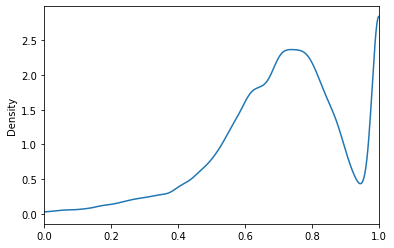

In [19]:
colsims.max(axis=1).head(100000).plot.density(xlim=[0,1])

# Debug matcher scores

In [20]:
ANNOTATION = '../backups/2019-10-22/sample-A-benno-clusters:benno/annotation_tables.tsv'
INOUTDIR = '../output/sample-A/15dec/'
SIMS = os.path.join(INOUTDIR, 'tablesims')

g = glob.glob(os.path.join(SIMS, '*.tsv'))
df = pd.concat([pd.read_csv(f, sep='\t') for f in g]).replace(0,float('nan'))
df = df[(~df['table1'].isna()) & (~df['table2'].isna())]

import pickle
tables = pickle.load(open(os.path.join(INOUTDIR, 'tableindices.pkl'), 'rb'))
annotation = pd.read_csv(ANNOTATION, sep='\t').set_index(['pgId', 'tbNr'])
annotation = {'%s-%s'%k:v for k,v in dict(annotation['clusterId']).items()}
annotation = {i:annotation.get('%s-%s'%(t['pgId'],t['tbNr']), None) for i,t in enumerate(tables)}
cluster1 = df['table1'].apply(lambda x: annotation.get(x,None))
cluster2 = df['table2'].apply(lambda x: annotation.get(x,None))
gold = (cluster1 == cluster2)
gold = df.assign(cluster1=cluster1, cluster2=cluster2, gold=gold)
gold = gold.set_index(['table1', 'table2'])['gold']

df = df.drop(columns=['columngauss', 'headerjacc', 'maxagg'])

colcomb = ['columnjacc', 'columntype', 'columncos']
df['columncomb'] = df[colcomb].max(axis=1)
df = df.drop(columns=colcomb)

df = df.set_index(['table1', 'table2'])

# df['agg'] = df.apply(np.nanmean, axis=1)
df.describe()

headercos    pagemwin     pagemwout    columncomb
count  53625.000000  562.000000  10597.000000  53796.000000
mean       0.683825    0.699403      0.018029      0.469022
std        0.162286    0.177514      0.047843      0.178016
min        0.037100    0.007300      0.000100     -0.068700
25%        0.585900    0.595000      0.002500      0.350000
50%        0.657700    0.698500      0.007700      0.444800
75%        0.750000    0.809600      0.019200      0.562000
max        1.000000    1.000000      1.000000      1.000000

In [21]:
df.assign(gold=gold).corr().style.background_gradient(cmap='Blues', axis=None)

In [22]:
df.idxmax(axis=1).value_counts()

headercos     48268
columncomb     5557
pagemwin        111
dtype: int64

## What happens when we fit a linear combination of matchers?

In [24]:
if 'lr' in df.columns:
    df = df.drop(columns=['lr'])
X = df.fillna(0)#.rank(method='max', pct=True)
# X = X.drop(columns=['columntype', 'pagemwin'])
# X = X.drop(columns=['columnjacc'])
X = X.drop(columns=['pagemwout'])

from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=5)
# lr = LogisticRegressionCV(cv=5, penalty='l1', solver='saga')

lr.fit(X, gold)

print('score:', lr.score(X, gold))
print('matcher coefficients: [intercept] =', lr.intercept_)
for coef, name in sorted(zip(lr.coef_[0], X.columns))[::-1]:
    print(f'{coef:5.2f} {name:<15s}')
    
formula = f'{lr.intercept_[0]:.0f}+'
formula += '+'.join(f'{k:.0f}*{v}' for k,v in zip(lr.coef_[0], X.columns))

sig = lambda x: 1 / (1 + np.exp(-x))
formula = f'sig({formula})'
print(formula)

for col in df:
    exec(f'{col} = df["{col}"].fillna(0)')
df['lr'] = eval(formula)

score: 0.9492732126965292
matcher coefficients: [intercept] [-15.38164402]
13.55 headercos      
 4.95 columncomb     
 1.70 pagemwin       
sig(-15+14*headercos+2*pagemwin+5*columncomb)


/export/scratch1/home/kruit/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


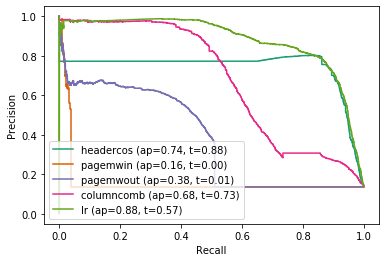

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
colors = plt.get_cmap('Dark2').colors
for col, c in zip(df.columns, colors):
    precision, recall, thresholds = precision_recall_curve(gold, df[col].fillna(0))
    ap = average_precision_score(gold, df[col].fillna(0))
    
    f1 = 2*precision*recall / (precision+recall)
    best_threshold = thresholds[np.nanargmax(f1)]
    
    plt.step(recall, precision, color=c,
             where='post', label=col + f' (ap={ap:.2f}, t={best_threshold:.2f})')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
None

## Is it easy to see which score is good at predicting gold matches?

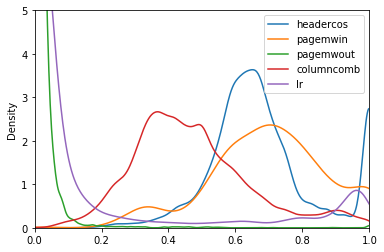

In [27]:
%matplotlib inline
df.plot.density(xlim=[0,1], ylim=[0,5])

CPU times: user 31.2 s, sys: 17.4 s, total: 48.7 s
Wall time: 23.7 s


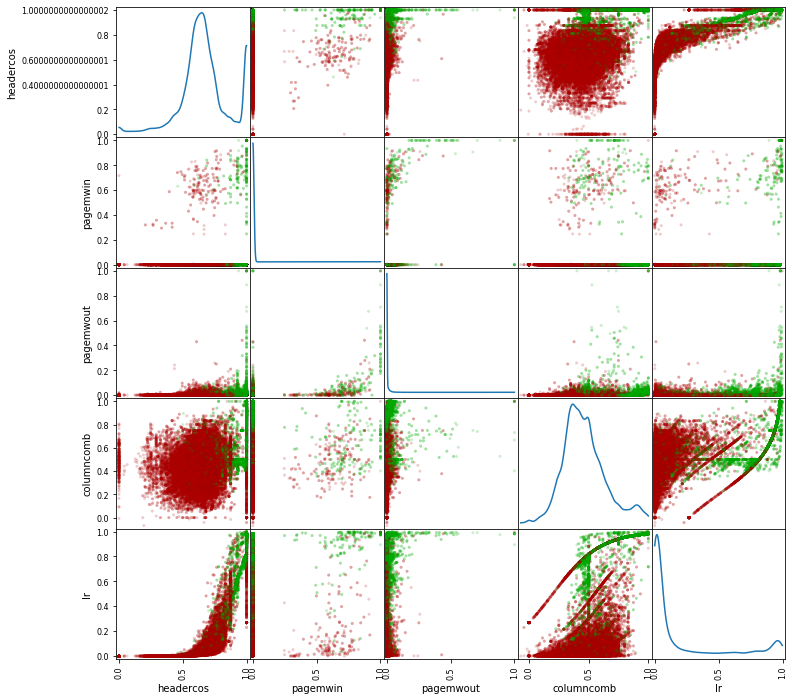

In [28]:
%%time
# color = df.apply(np.nanmean, axis=1).apply(lambda x: '#00aa00' if x>0.5 else '#aa0000')
color = gold.apply(lambda x: '#00aa00' if x else '#aa0000')
pd.plotting.scatter_matrix(df.fillna(0), color=color, alpha=0.2, diagonal='kde', figsize=(12, 12))
None

# Eval Aggregations for Louvain clustering

In [29]:
import community
import networkx as nx
from sklearn.metrics import homogeneity_completeness_v_measure

def cluster(nodes, edges):
    G = nx.Graph([(int(u), int(v)) for u,v in edges] + [(i,i) for i in nodes])
    return community.best_partition(G)
    
    

def hom_com_vm_curve(series, k=10):
    thresholds = sorted(set( series.quantile(np.arange(0,1,1/k)) ))
    nodes = set(t for t,c in annotation.items() if c is not None)
    labels_true = [annotation[t] for t in nodes]
    
    for threshold in thresholds:
        edges = series.index[(series > threshold)]
        partition = cluster(nodes, edges)
        
        labels_pred = [partition[t] for t in nodes]
        hom, com, vm = homogeneity_completeness_v_measure(labels_true, labels_pred, beta=1.0)
        yield {
            'labels_pred': labels_pred,
            'threshold': threshold,
            'homogeneity': hom,
            'completeness': com,
            'v_measure': vm
        }



nodes = set(t for t,c in annotation.items() if c is not None)
labels_true = [annotation[t] for t in nodes]
partition = cluster(nodes, gold.index[gold])
labels_pred = [partition[t] for t in nodes]
hom, com, vm = homogeneity_completeness_v_measure(labels_true, labels_pred, beta=1.0)
print(f'Gold scores: {hom:.2f} {com:.2f} {vm:.2f}')

Gold scores: 1.00 0.99 0.99


In [30]:
%%time
score_curve = {}
for method in ['headercos', 'columncomb', 'lr']:
    print(method)
    score_curve[method] = pd.DataFrame.from_records( hom_com_vm_curve(df[method]) )
    

headercos
columncomb
lr
CPU times: user 1min 5s, sys: 473 ms, total: 1min 5s
Wall time: 1min 6s


           headercos  AR: 0.00 AMI: 0.00
          columncomb  AR: 0.25 AMI: 0.42
                  lr  AR: 0.62 AMI: 0.69


[(0.9, 1), Text(0, 0.5, 'Completeness'), (0, 1), Text(0.5, 0, 'Homogeneity')]

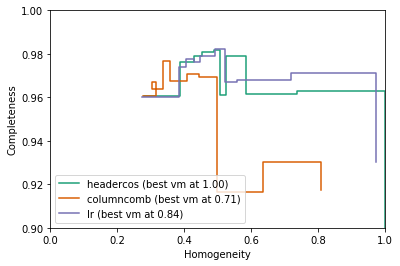

In [31]:
import matplotlib.pyplot as plt
from sklearn import metrics

nodes = set(t for t,c in annotation.items() if c is not None)
labels_true = [annotation[t] for t in nodes]
    
ax = plt.axes()
colors = plt.get_cmap('Dark2').colors
for (method, scores), c in zip(score_curve.items(), colors):
    best_index = np.nanargmax(scores['v_measure'])
    best_threshold = scores['threshold'][best_index]
    
    labels_pred = scores['labels_pred'][best_index]
    ar = metrics.adjusted_rand_score(labels_true, labels_pred)
    ami = metrics.adjusted_mutual_info_score(labels_true, labels_pred, average_method='arithmetic')
    print(f'{method:>20s}  AR: {ar:.2f} AMI: {ami:.2f}')
    
    plt.step(scores['homogeneity'], scores['completeness'], color=c,
             where='post', label=f'{method} (best V at {best_threshold:.2f})')
plt.legend()
ax.set(xlabel='Homogeneity', ylabel='Completeness', xlim=[0,1], ylim=[.9,1])
# None